In [1]:
import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List
from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation

In [7]:
# get image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.save('cat_on_sofa.jpg')

In [2]:
# load with cv2, and model expects BGR not RGB
# image = cv2.imread('cat_on_sofa.jpg')
image = cv2.imread('woman_front_cam.jpeg')

In [3]:
cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).shape

(360, 540)

## Hugging Face

In [4]:
feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/deeplabv3-mobilevit-xx-small")
model = MobileViTForSemanticSegmentation.from_pretrained("apple/deeplabv3-mobilevit-xx-small")

/opt/anaconda3/envs/webcam-app/lib/python3.10/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


In [5]:
model.config.id2label

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [6]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
target_sizes = [image.shape[:2]]
# or outputs.logits.argmax(1)[0]
all_mask = feature_extractor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)[0]

In [7]:
np.unique(all_mask)

array([ 0, 15])

In [40]:
w, h = target_sizes[0][1], target_sizes[0][0]
t = outputs.logits[0][15] > (0.6*outputs.logits[0][15].max())
t = t.numpy()
t = t.astype('uint8') * 255
selected_mask = cv2.resize(t, (w, h))

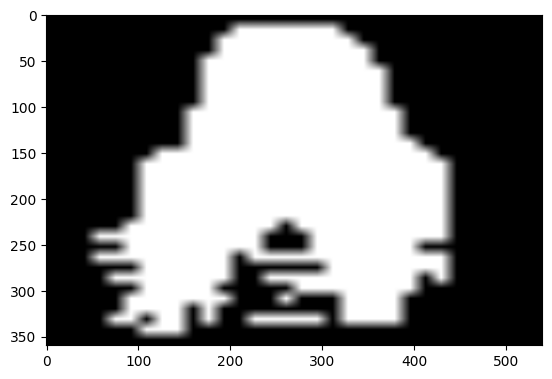

In [41]:
plt.imshow(cv2.cvtColor(selected_mask, cv2.COLOR_GRAY2BGR))

In [57]:
def bin_mask_from_cls_idx(full_mask: torch.Tensor, cls_idx_list: List[int]) -> torch.Tensor:
    mask = full_mask.clone()
    for i in cls_idx_list:
        mask[mask==i] = 255
    mask[mask!=255] = 0
    return mask

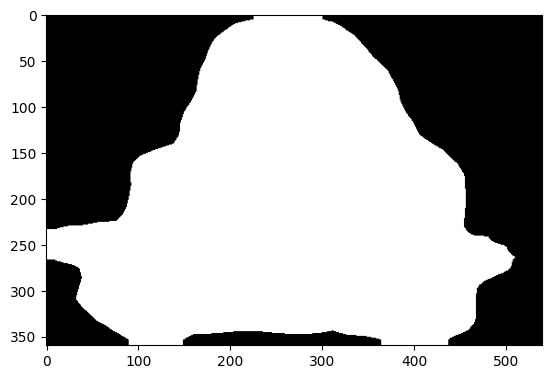

In [26]:
# 0 -> bg, 8 -> cat
selected_mask = bin_mask_from_cls_idx(all_mask, [15])
plt.imshow(selected_mask, cmap='gray')

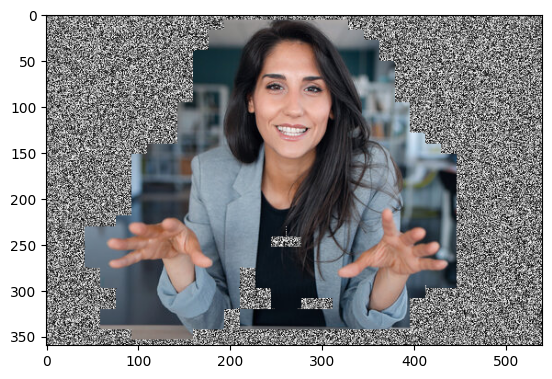

In [30]:
noise = np.random.randint(0, 255, size=(image.shape[0], image.shape[1], 1), dtype=np.uint8)
final_img = np.where(np.expand_dims(selected_mask, 2), image, noise)
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

## Mediapipe

In [1]:
import mediapipe as mp

In [14]:
image = cv2.imread('woman_front_cam.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
solution = mp.solutions.selfie_segmentation

In [5]:
model = solution.SelfieSegmentation(model_selection=1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
res = model.process(image)

In [16]:
res.segmentation_mask.shape

(360, 540)

In [17]:
thr = 0.5
selected_mask = res.segmentation_mask > thr

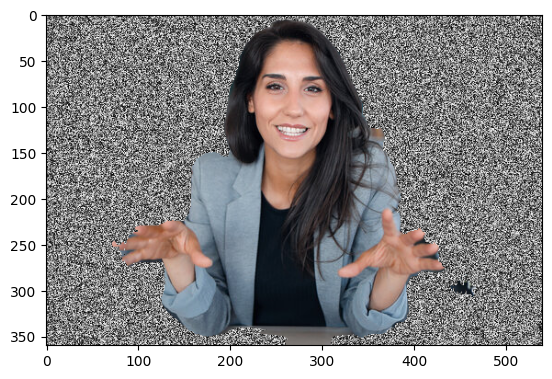

In [19]:
noise = np.random.randint(0, 255, size=(image.shape[0], image.shape[1], 1), dtype=np.uint8)
final_img = np.where(np.expand_dims(selected_mask, 2), image, noise)
plt.imshow(final_img)